# EXTERNAL SHOCK MODEL - MAXI J1820+070


In [1]:
import numpy as np
import sys
import math
from numpy import linspace
import scipy
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import matplotlib as mpl
import corner
import emcee
import multiprocess
from multiprocess import Pool
import warnings
import pylab
import datetime as dt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

warnings.simplefilter('error')
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', DeprecationWarning)


%matplotlib inline

print('Using the following packages:\n')
print('scipy ',scipy.__version__)
print('matplotlib ',mpl.__version__)
print('numpy ',np.__version__)
print('corner ',corner.__version__)
print('emcee ',emcee.__version__)

Using the following packages:

scipy  1.9.1
matplotlib  3.6.0
numpy  1.23.3
corner  2.2.2
emcee  3.1.2


In [2]:
plt.style.use('default')




## Model Functions

In [3]:
#Computing the Lorentz factor (squared) of the swept up material, with an interpolated adiabatic index
def Gamma_sh_square(Gamma):
    adiab_index = (4*Gamma+1)/(3*Gamma)
    return ((Gamma+1)*(adiab_index*(Gamma-1)+1)**2)/(adiab_index*(2-adiab_index)*(Gamma-1) +2)

#Simple v/c of the jet from the Lorentz factor
def beta(Gamma):
    #if loop prevents beta from being < 0.
    if Gamma >1:
        return np.sqrt(1-1./Gamma**2)
    else:
        return(0.)
    
# two parts of the mass_swept_cavity function
def R_bubble(phi_jet,R_pc,delta,n_ism):
    return((phi_jet)**2 * (n_ism/delta)  * R_pc**3)
def R_ism(phi_jet,R_pc,delta,zeta,R_cavity_pc,n_ism):
    return((phi_jet)**2 * (n_ism/delta)  *((zeta*R_cavity_pc)**3 + delta*(R_pc**3 - (zeta*R_cavity_pc)**3)))

#The growing mass swept up by the jet, with the scaling factor absorbing the large numbers.
#Before reaching the cavity radius R_cavity_pc, the jet moves in a an "empty" bubble with a density n_ism/delta.
#After reaching R_cavity_pc (the cavity wall), we sum the mass swept up so far with the mass swept up in a normal n_ism ISM, after a jump of order delta in the ISM density
def mass_swept_cavity(R_pc, R_cavity_pc, delta,zeta0,phi_jet,n_ism,flag):
    c=3e10
    m_p = 1.672e-24
    pc_to_cm = 3.086e18
    
    scaling_factor = (m_p*(c**2)*(np.pi/3)*pc_to_cm**3)
    if flag=='app':
        zeta=1.
    elif flag=='rec':
        zeta=zeta0
    R_term = np.where(R_pc < zeta*R_cavity_pc, R_bubble(phi_jet,R_pc,delta,n_ism), R_ism(phi_jet,R_pc,delta,zeta,R_cavity_pc,n_ism))
    return scaling_factor*R_term

#In the model we assume energy conservation (adiabatic expansion). This function is Equation 2 from Steiner & McClintock. 2012.
#M_0 is obtained from E_0/(Gamma0-1)c**2. This function is used through fsolve to obtain the Lorentz factor Gamma that satisfies energy conservation, returning 0.
#E0_45 is E0 in units of 10^45 erg, R_pc and R_cavity_pc are in units of parsecs.
def energy_cavity(Gamma, params):
    R_pc, Gamma0, E0_45, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag= params
    return -10**(E0_45) + ((Gamma-1)/(Gamma0-1))*10**(E0_45) + (0.73-0.38*beta(Gamma)) * (Gamma_sh_square(Gamma) - 1)*mass_swept_cavity(R_pc, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag)


#Function for the numerical solution of the "energy conservation constraint".
#It is used to obtain the Lorentz factor at every time step of the integration of the differential equation governing the jet motion.
#The first guess for Gamma is Gamma0, with no values below 1.001 (I first saw that it was helping for stability, but probably it is not really necessary)
def Gamma_t(R_pc, parameters):
    Gamma0, E0_45, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag = parameters
    pars = [R_pc, Gamma0, E0_45, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag]
    Gamma_new = fsolve(energy_cavity, Gamma0, args=pars,full_output=1)
    #if fsolve fails we set Gamma_new = Gamma0, and keep track of when a fail occurs (0=fail, 1=sucessful)
    if Gamma_new[2] == 1:
        return Gamma_new[0],1
    else:
        return Gamma0,0

#Computing the derivative of R(t), to be integrated with scipy.odeint. At every time step the Lorentz factor is obtained using the distance information (R_pc).
#We only test an approaching jet component, as we know that this is the case for MAXI J1348-630.
#Theta_i is the inclination angle.
def jet_motion_cavity(y, t, Gamma0, E0_45, theta_jet, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag):
    #Conversion to pc, as y is in cm
    pc_to_cm = 3.086e18
    c=3e10
    R_pc = y/pc_to_cm
    pars_app = [Gamma0, E0_45, R_cavity_pc, delta,zeta,phi_jet,n_ism,flag]
    Gamma,sol = Gamma_t(R_pc, pars_app)
    #Equation 4 of Steiner & McClintock. 2012
    if sol==1 and flag=='app':
        dR_dt = (beta(Gamma)*c/(1-beta(Gamma)*np.cos(theta_jet)))
    elif sol==1 and flag=='rec':
        dR_dt = (beta(Gamma)*c/(1+beta(Gamma)*np.cos(theta_jet)))
    #if fsolve fails in Gamma_t function, we set derivative here to 0 to induce a warning in 
    #the ODE solver in total_motion function
    else:
        dR_dt=0.
    #We return cm per day
    return dR_dt*86400

#solve the differential equation in jet_motion_cavity function, output angular distance as function of time
def total_motion(p,time_array0,flag):
    Gamma0, E0_45, theta_i,phi_j, R_cavity_pc, delta,zeta,D,R0,n_ism,tej = p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10]
    d_cm=D*1000*3e18
    theta_rad=theta_i*np.pi/180.
    phi_rad=phi_j*np.pi/180.
    #for time_array in absolute MJD, convert to time after ejection
    time_array=time_array0-(tej+58300)
    #add a 0 to beginning of time_array if needed for differential equation solver to work properly
    if time_array[0]!=0.:
        time_array=np.insert(time_array,0,0.)
        inde=1
    else:
        inde=0
    
    time_array_diff = np.diff(time_array)
    
    #Ensuring that values in the time array increase monotonically after the t_ej subtraction:
    #the proposal cannot bring a walker in a point of the parameter space where t_ej is > 58551
    if time_array_diff[0] > 0:
        
        #if fsolve fails, with dR_dt=0, odeint fails with ODSint warning. We turn this warning to an error
        #and catch in a try and accept statment, so we can set logprob=-inf at this point in parameter space.
        try:
            alpha_app = odeint(jet_motion_cavity, t=time_array, y0=R0, 
                               args=(Gamma0, E0_45, theta_rad, R_cavity_pc, delta,zeta,phi_rad,n_ism,flag)
                              )* (np.sin(theta_rad) /d_cm)* (3600 * 180 / np.pi)
        except scipy.integrate.odepack.ODEintWarning:
            alpha_app=np.zeros(len(time_array))
        return(alpha_app.flatten()[inde:])
    
    else:
        alpha_app=np.zeros(len(time_array))
        return(alpha_app.flatten()[inde:])

In [4]:
multiprocess.cpu_count()

10

## Log likelihood, priors, and log probability

In [5]:
#log likelihood
def log_likelihood(p, x, y, yerr,mod_type):
    Gamma0, E0_45, theta_i,phi_j, R_cavity_pc, delta,zeta,D,R0,n_ism,tej = p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10]
    if mod_type=='single':
        model= total_motion(p,x[0],'app')
        llike=-0.5*np.nansum(np.log(2*np.pi*yerr[0]**2))-np.nansum((y[0]-(model))**2/(2*yerr[0]**2))
    elif mod_type=='double':
        x_app,x_rec=x[0],x[1]
        y_app,y_rec=y[0],y[1]
        sigma_app,sigma_rec=yerr[0],yerr[1]
        model_app = total_motion(p,x_app,'app')
        model_rec = total_motion(p,x_rec,'rec')
        re=[]
        re.append(-0.5*np.nansum(np.log(2*np.pi*sigma_app**2))-np.nansum((y_app-(model_app))**2/(2*sigma_app**2)))
        re.append(-0.5*np.nansum(np.log(2*np.pi*sigma_rec**2))-np.nansum((y_rec-(model_rec))**2/(2*sigma_rec**2)))
        llike=np.nansum(re)
    return llike
#log prior
def lprior(pval,fixp,guess,time_array,mod_type):
    #allow some parameters to be fixed
    pv=[]
    for i in range(0,len(fixp)):
        if fixp[i]==True:
            pv.append(guess[i])
        elif fixp[i]==False:
            pv.append(pval[i])
        else:
            raise ValueError("The fixed parameter array values can only be True or False")
    p=np.array(pv)
    Gamma0, E0_45, theta_i,phi_j, R_cavity_pc, delta,zeta,D,R0,n_ism,tej = p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10]
    #
    #if a parameter is fixed we comment out its prior
    prior = 0.0
    prior += ss.uniform.logpdf(tej,loc=1.,scale=20)#ejection time=tej+58500
    prior += ss.loguniform.logpdf(Gamma0, 1., 100.)
    prior += ss.uniform.logpdf(E0_45,loc=35.,scale=20.)
    prior += ss.norm.logpdf(theta_i,loc=64.,scale=5.) + ss.norm.logpdf(theta_i,loc=0.,scale=90.)
    #prior += ss.cosine.logpdf((np.pi*3/2 + np.pi*(theta_i)/180),loc=0.,scale=45) + ss.uniform.logpdf(theta_i,loc=0.,scale=45.)
    #prior += ss.uniform.logpdf(phi_j,loc=0.,scale=20.)
    #prior += ss.uniform.logpdf(R_cavity_pc,loc=0.,scale=2)
    #prior += ss.loguniform.logpdf(delta,1, 1e4)
    #prior += ss.uniform.logpdf(delta,loc=0.1,scale=1e4)
    #prior += ss.uniform.logpdf(zeta,loc=0.01,scale=10.)
    #prior += ss.norm.logpdf(D,loc=2.96,scale=0.33) + ss.uniform.logpdf(D,loc=0.,scale=5.)
    #prior += ss.uniform.logpdf(R0,loc=1.,scale=100.)
    #prior += ss.uniform.logpdf(n_ism,loc=0.,scale=10.)
    #
    #setting to -inf if ODEint and fsolve have failed
    if mod_type=='single':
        if np.all(total_motion(p,time_array[0],'app')==0):
            return(-np.inf)
    elif mod_type=='double':
        if np.all(total_motion(p,time_array[0],'app')==0):
            return(-np.inf)
        if np.all(total_motion(p,time_array[1],'rec')==0):
            return(-np.inf)
    if np.isnan(prior):
        return(-np.inf)
    return(prior)
#log probability
def log_probability(p, x, y, yerr,fixp,guess,mod_type):
    lp = lprior(p,fixp,guess,x,mod_type)
    return lp + log_likelihood(p, x, y, yerr,mod_type)

# ISM density constraints (Heinz 2002)

In [20]:
convX = 4*np.pi*(2.96*1000.)**2*(3.086e18)**2
flux_05_200_kev = 3.8e-8  + 1.4e-7 
L_X_bolom = convX * flux_05_200_kev 
print(("Bolometric X-ray flux 0.5-200 keV {:e} erg/cm2/s\n".format(flux_05_200_kev)))
print(("Bolometric X-ray luminosity 0.5-200 keV {:e} erg/s\n".format(L_X_bolom)))

#MAX ENERGY
timescale = (7*86400)/24
eta_jet_max = 1.0
eta_rad = 0.1
dopp_delta_app = 1./(2.0 * (1 - beta(2.0) * np.cos(64*np.pi/180))) #Wood
E_max = (timescale) * L_X_bolom * eta_jet_max / (2*eta_rad)
print(("Max energy for a single jet {:e} erg\n".format(E_max)))

phi_5 = 2/(5)
Gamma_5 = 2.0/5
E_44 = E_max/(10**44)
D_1820_cm = 3.086e18 * 1000 * 2.96
d_slow_16 = (D_1820_cm * np.sin(8 / 3600 * np.pi/180)/(np.sin(64 * np.pi/180)) )/ (1e16)

print(("Upper limit on ISM density {:e} cm^(-3)\n".format(n_max)))
print(("Distance traveled {:e} cm\n".format(d_slow_16*1e16)))

Bolometric X-ray flux 0.5-200 keV 1.780000e-07 erg/cm2/s

Bolometric X-ray luminosity 0.5-200 keV 1.866402e+38 erg/s

Max energy for a single jet 2.351666e+43 erg

Upper limit on ISM density 1.499888e-04 cm^(-3)

Distance traveled 3.941779e+17 cm



## Data

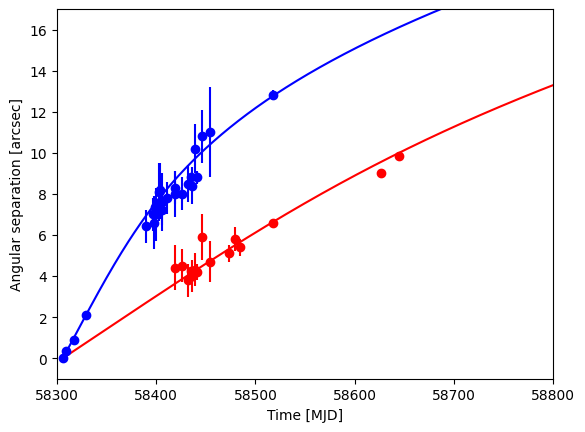

In [23]:
###########################
#MAXI J1820+070

data_app=np.loadtxt('maxij1820_angular_separation_approaching.txt')
times_app=data_app[:,0]
ang_sep_app=data_app[:,1]
ang_sep_err_app=data_app[:,2]

data_rec=np.loadtxt('maxij1820_angular_separation_receding.txt')
times_rec=data_rec[:,0]
ang_sep_rec=data_rec[:,1]
ang_sep_err_rec=data_rec[:,2]


Gamma0_guess = 2.6#Wood
E0_45_guess = 42.6#Max density and accretion power
theta_i_guess = 59
phi_j_guess = 1.0
R_cavity_pc_guess = 0.0 
delta_guess = 1.0
zeta_guess = 1.0
dkpc_guess = 2.96
R0_guess = 1e8
n_ism_guess = 1e-4
t_ej_guess = 5.96#Wood


#Gamma0, E0_45, theta_i,phi_j, R_cavity_pc, delta,zeta (rec/app),dkpc,R0,n_ism,tej(+58500)
p=[Gamma0_guess,E0_45_guess,theta_i_guess,phi_j_guess,R_cavity_pc_guess,delta_guess,zeta_guess,dkpc_guess,R0_guess,n_ism_guess,t_ej_guess]
times = np.arange(p[10]+58300,p[10]+58300+1000,1)
ang_sep_true_app=total_motion(p,times,'app')
ang_sep_true_rec=total_motion(p,times,'rec')


#plot data with our best initial guess to check our model
fig=plt.figure()
plt.errorbar(times_app,ang_sep_app,yerr=ang_sep_err_app,marker='o',ls='',color='b')
plt.plot(times,ang_sep_true_app,color='b')
plt.errorbar(times_rec,ang_sep_rec,yerr=ang_sep_err_rec,marker='o',ls='',color='r')
plt.plot(times,ang_sep_true_rec,color='r')
plt.xlim(58300, 58800)
plt.ylim(-1, 17)
plt.xlabel('Time [MJD]')
plt.ylabel('Angular separation [arcsec]')


#make lists of approaching and receeding data to pass to log prob later
Times=[times_app,times_rec]
Ang_Sep=[ang_sep_app,ang_sep_rec]
Ang_Sep_Err=[ang_sep_err_app,ang_sep_err_rec]

###########################

plt.savefig("maxi1820_discrete_ejecta_guess_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)

## Sampling

In [24]:
#set initial guess, which parameters to fix, and initial walker positions (tight ball around initial guess)

#Gamma0, E0_45, theta_i,phi_j, R_cavity_pc, delta,zeta (rec/app),dkpc,R0,n_ism,tej(+58500)
#setting R_cavity_pc=0 and delta=1 would be no cavity.
mod_type='double'

guess=[Gamma0_guess,E0_45_guess,theta_i_guess,phi_j_guess,R_cavity_pc_guess,delta_guess,zeta_guess,dkpc_guess,R0_guess,n_ism_guess,t_ej_guess]

Gamma0_fixed = False
E0_45_fixed = False
theta_i_fixed = False
phi_j_fixed = True
R_cavity_pc_fixed = True 
delta_fixed = True
zeta_fixed = True
dkpc_fixed = True
R0_fixed = True
n_ism_fixed = True
t_ej_fixed = False


fixp=[Gamma0_fixed,E0_45_fixed,theta_i_fixed,phi_j_fixed,R_cavity_pc_fixed,delta_fixed,zeta_fixed,dkpc_fixed,R0_fixed,n_ism_fixed,t_ej_fixed]

#FIXED PHI FOR DEGENERACY

ndim = 11
print(('number of dimensions is ',ndim))
nwalkers = ndim*10
p0 = np.zeros((nwalkers,ndim))
for idx,thisguess in enumerate(guess):
    if fixp[idx]==True:
        p0[:,idx] = thisguess
    elif fixp[idx]==False:
        p0[:,idx] = (np.random.randn(nwalkers)*0.001+1.0)*thisguess

number of dimensions is  11


In [25]:
#test what the log prob is at our initial guess to make sure its not inf!
log_probability(guess, Times, Ang_Sep, Ang_Sep_Err,fixp,guess,mod_type)

-194.9133211363419

In [26]:
#TRY 400 steps
nBurn=50
nSamp=300

max_number_processes = 8
pool_max = multiprocess.Pool(max_number_processes)

with pool_max as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=[Times, Ang_Sep, Ang_Sep_Err,fixp, guess, mod_type], pool=pool)
    
    pos,prob,state=sampler.run_mcmc(p0, nBurn, progress=True,skip_initial_state_check=True)
    sampler.reset()
    pos,prob,state=sampler.run_mcmc(pos, nSamp, progress=True,skip_initial_state_check=True)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
100%|█████████████████████████████████████████| 300/300 [24:17<00:00,  4.86s/it]


## Diagnostic Plots

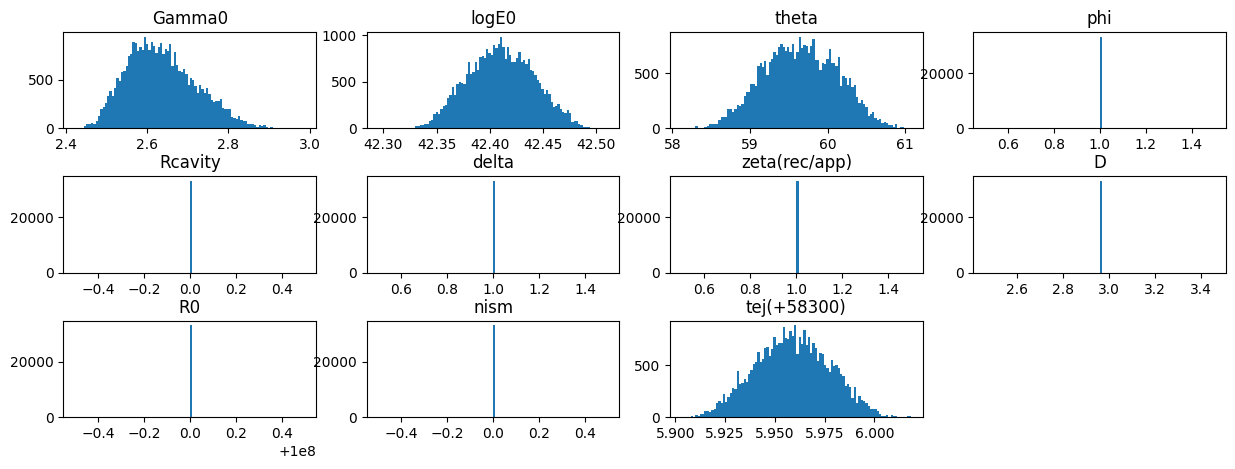

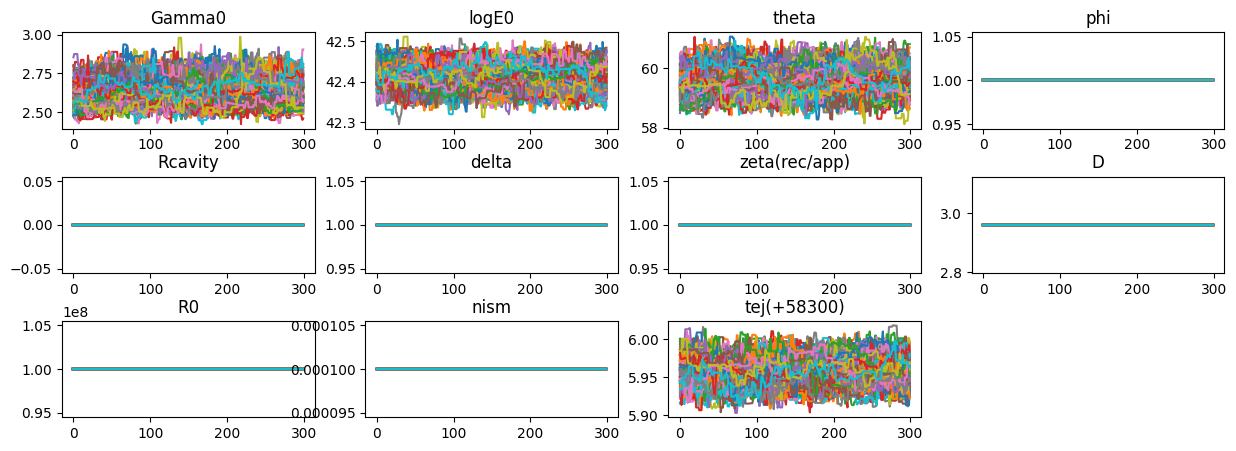

In [27]:
##With cavity
#plot posteriors
pname=['Gamma0', 'logE0', 'theta','phi', 'Rcavity', 'delta','zeta(rec/app)','D','R0','nism','tej(+58300)']
figa = plt.figure(figsize=(15,5))
for i in range(0,ndim):
    plt.subplot(3,4,i+1)
    patches = plt.hist(sampler.flatchain[:,i],bins=100)
    plt.title(pname[i])
figa.subplots_adjust(hspace=.5)

#plot traces - should look like fuzzy caterpillars if solution if converged
figb = plt.figure(figsize=(15,5))
for i in range(0,ndim):
    plt.subplot(3,4,i+1)
    plt.plot(sampler.chain[:,:,i].T)
    plt.title(pname[i])
figb.subplots_adjust(hspace=.5)

plt.savefig("maxi1820_discrete_ejecta_model_diagnostic_chains_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)
#plt.savefig("maxi1348_diagnostic_chains_test1.png", dpi=300, bbox_inches='tight')

## Results

In [29]:
##With cavity
#print medians and 1 sigma intervals of our posteriors
def confidenceInterval(y):
    median=np.median(y)
    pct15=np.percentile(y,15)
    pct85=np.percentile(y,85)
    list1=np.array([median,median-pct15,pct85-median])
    return list1

for i in range(0,ndim):
    a=confidenceInterval(sampler.flatchain[:,i])
    print(a)


bestp_final = np.median(sampler.flatchain,axis=0)

print(("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))))

[2.62825321 0.07933518 0.10262039]
[4.24103172e+01 3.32246639e-02 3.35379689e-02]
[59.64620121  0.50875244  0.52148407]
[1. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[2.96 0.   0.  ]
[1.e+08 0.e+00 0.e+00]
[0.0001 0.     0.    ]
[5.95883553 0.01968379 0.02053168]
Mean acceptance fraction: 0.440


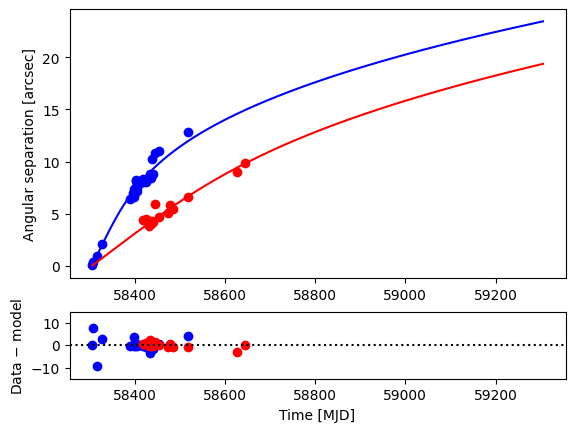

In [30]:
##With cavity 
#plot best-fit model over data with residuals
times= np.arange(bestp_final[10]+58300,bestp_final[10]+58300+1000,1)
fig,axes = plt.subplots()
rc('text', usetex=False)
#font = {'family' : 'serif','weight' : 'bold','size': '14'}
#rc('font', **font)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1=plt.subplot(gs[0])
ax2=plt.subplot(gs[1],sharex=ax1)
if mod_type=='single':
    mod=total_motion(bestp_final,times,'app')
    ax1.plot(Times[0],Ang_Sep[0],marker='o',ls='',color='b')
    ax1.plot(times,mod,color='k')
    ax1.set_ylabel('Angular separation [arcsec]')
    ax2.set_ylabel('Data $-$ model')
    ax2.set_xlabel('Time [MJD]')
    ax2.plot(Times[0],(Ang_Sep[0]-total_motion(bestp_final,Times[0],'app'))/abs(Ang_Sep_Err[0]),marker='o',ls='',color='b')
elif mod_type=='double':
    mod_app=total_motion(bestp_final,times,'app')
    mod_rec=total_motion(bestp_final,times,'rec')
    ax1.plot(Times[0],Ang_Sep[0],marker='o',ls='',color='b')
    ax1.plot(Times[1],Ang_Sep[1],marker='o',ls='',color='r')
    ax1.plot(times,mod_app,color='b')
    ax1.plot(times,mod_rec,color='r')
    ax1.set_ylabel('Angular separation [arcsec]')
    ax2.set_ylabel('Data $-$ model')
    ax2.set_xlabel('Time [MJD]')
    ax2.plot(Times[0],(Ang_Sep[0]-total_motion(bestp_final,Times[0],'app'))/abs(Ang_Sep_Err[0]),marker='o',ls='',color='b')
    ax2.plot(Times[1],(Ang_Sep[1]-total_motion(bestp_final,Times[1],'rec'))/abs(Ang_Sep_Err[1]),marker='o',ls='',color='r')
ax2.axhline(y=0,ls=':',color='k')
ax2.set_ylim(-15,15)

plt.savefig("./MAXIJ1820_JET_ANGSEP_FIT_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)


#GOODNESS OF FIT

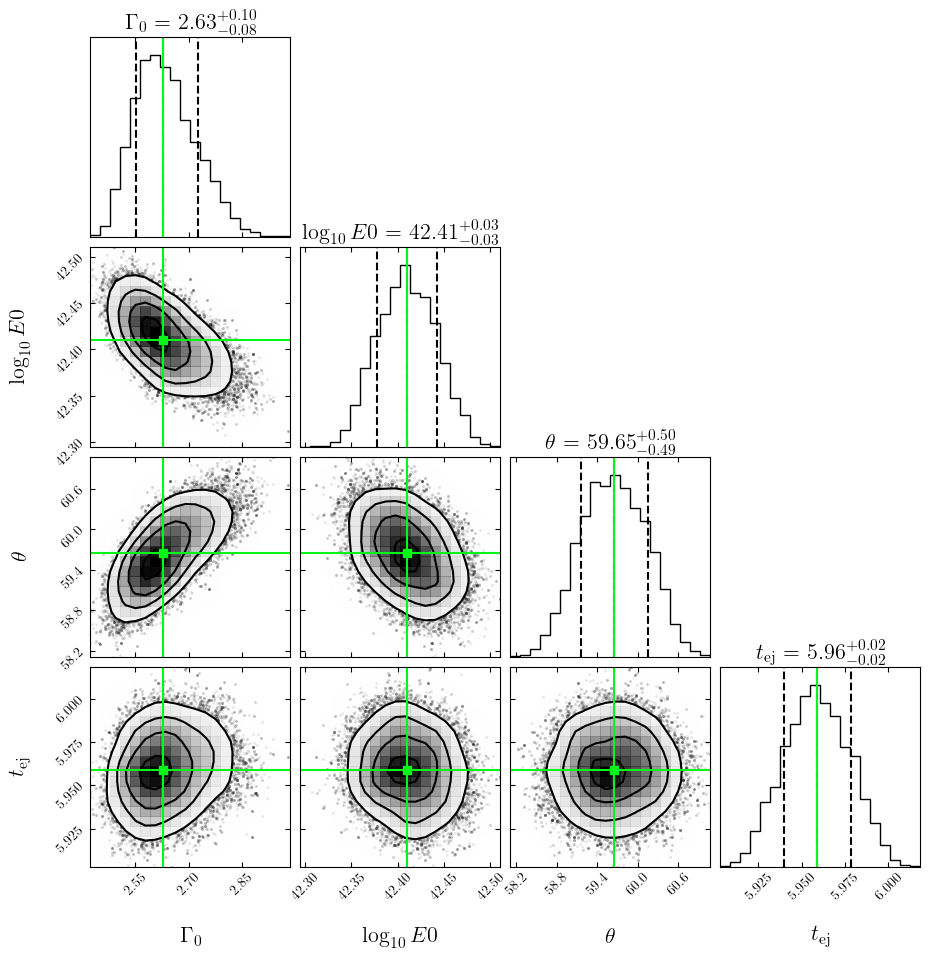

In [31]:
data_corner = np.hstack([sampler.chain[:, :, 0].reshape((-1, 1)),sampler.chain[:, :, 1].reshape((-1, 1)),
                  sampler.chain[:, :, 2].reshape((-1, 1)),
                  sampler.chain[:, :, 10].reshape((-1, 1))])

rc('text', usetex=True)
# Plot it.
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.top'] = 'on'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right'] = 'on'
figure = corner.corner(data_corner, labels=[r"$\Gamma_0$",r"$\log_{10}{E0}$",r"$\theta$",r"$t_{\rm ej}$"],
                       quantiles=[0.16,0.5,0.84],label_kwargs={"size": 16},\
                       show_titles=True, title_kwargs={"fontsize": 16},\
                      plot_contours=True,truth_color='#08F51A',\
                       truths=[bestp_final[0],bestp_final[1],bestp_final[2],bestp_final[10]],smooth=True)

plt.savefig("./MAXIJ1820_JET_ANGSEP_FIT_CORNER_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)

# $M_0$ estimation

2
Best estimation of $M_0$ :  1.7501807490459896e+21
Upper error :  0.0387697619965266
Lower error :  0.03852828720506807
M_0 best 1.750181e+21 + 1.634259e+20 - 1.485787e+20


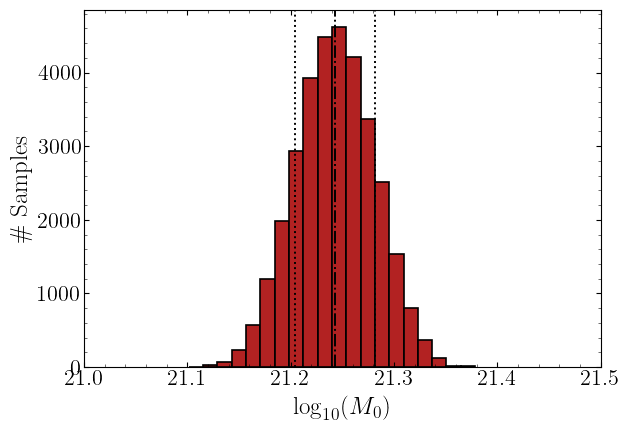

In [34]:
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

c=3e10
m_p = 1.672e-24

import random
n = random.randint(0,2)
print(n)
Gamma_0_chain = sampler.chain[:, :, 0].reshape((-1, 1))

LogE0_chain = sampler.chain[:, :, 1].reshape((-1, 1))

M0_array = np.zeros(len(Gamma_0_chain))

for i in range(len(Gamma_0_chain)):
    
                k = random.randint(0, len(Gamma_0_chain)-1)
        
                j = random.randint(0, len(Gamma_0_chain)-1)

                M0_array[i] = (10**LogE0_chain[k])/((Gamma_0_chain[j]-1) * (c**2))
                
                          
print(("Best estimation of $M_0$ : ", np.quantile(M0_array, .50))) 
print(("Upper error : ", (np.quantile(np.log10(M0_array), .84) - np.quantile(np.log10(M0_array), .50))))
print(("Lower error : ", (np.quantile(np.log10(M0_array), .50) - np.quantile(np.log10(M0_array), .16)))) 


log_M_0_best = np.quantile(np.log10(M0_array), .50)
M_0_best = 10**np.quantile(np.log10(M0_array), .50)
delta_plus = np.quantile(np.log10(M0_array), .84) - np.quantile(np.log10(M0_array), .50)
delta_minus = np.quantile(np.log10(M0_array), .50) - np.quantile(np.log10(M0_array), .16)
err_plus_M_0 =  10**(log_M_0_best+delta_plus) - 10**(log_M_0_best)
err_minus_M_0 =  10**(log_M_0_best) - 10**(log_M_0_best-delta_minus)


print(("M_0 best {:e} + {:e} - {:e}".format(M_0_best, err_plus_M_0, err_minus_M_0)))

fig,axes = plt.subplots()
rc('text', usetex=True)

gs = gridspec.GridSpec(1,1)
ax1=plt.subplot(gs[0])

ax1.hist(np.log10(M0_array), bins = 20, edgecolor='black', linewidth=1.2, color='firebrick')

ax1.axvline(x=np.quantile(np.log10(M0_array), .84), color='k', linestyle=':')
ax1.axvline(x=np.quantile(np.log10(M0_array), .50), color='k', linestyle='-.')
ax1.axvline(x=np.quantile(np.log10(M0_array), .16), color='k', linestyle=':')

ax1.set_xlabel('$\\log_{10}(M_0)$', fontsize = 18)
#plt.xlabel('Time [MJD $-$ 58500]', fontsize =16)
plt.ylabel('$\#$ Samples', fontsize =18)
#plt.ylim(0, 1.0)
plt.xlim(21.0, 21.5)
plt.tick_params(axis ='both',which='both',direction = 'in', top=True, right=True, labelsize = 16, pad=2)
plt.minorticks_on()
#plt.xticks(rotation=30)
plt.tight_layout()
#pylab.setp(ax1.get_xticklabels(), visible=False)
plt.savefig("MAXIJ1820_JET_MASS_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)

# Mass outflow rate and comparison with mass accretion rate

In [36]:
dopp_delta_app_fit = 1./(bestp_final[0] * (1 - beta(bestp_final[0]) * np.cos(bestp_final[2]*np.pi/180)))

outflow_rate = M_0_best/(timescale*dopp_delta_app_fit)

print((r'Mass outflow rate {:e} g/s'.format(outflow_rate)))

mass_accretion_rate = 2e18 #Fabian, Marino 2018-2020

print((r'Ratio mass outflow/accretion rate {:e} g'.format(outflow_rate/mass_accretion_rate)))

Mass outflow rate 9.723150e+16 g/s
Ratio mass outflow/accretion rate 4.861575e-02 g


# Comparisons



In [37]:
#EDDINGTON LUMINOSITY
bh_mass = 10
L_edd = 1.3 * 10**(38) * bh_mass

timescale_rest_frame = dopp_delta_app*timescale
print(("X-ray bolometric luminosity on MJD 58521: {:e} erg/s,\n".format(L_X_bolom)))
print(("Assuming an observed rising timescale of {:e} days\n".format(timescale/86400)))
print(("Assuming a rest frame rising timescale of {:e} days\n".format(timescale_rest_frame/86400)))
print(("Jet power assuming rest frame timescale {:e} erg/s\n".format((10**(bestp_final[1]))/(timescale_rest_frame))))
print(("Ratio between transient jet power and X-ray bolom. luminosity: {:e}\n".format(((10**(bestp_final[1]))/(timescale_rest_frame))/L_X_bolom)))
print(("Ratio between ejecta power and Eddington luminosity: {:e}\n".format(((10**(bestp_final[1]))/(timescale_rest_frame))/L_edd)))
print(("Ratio between ejecta power and max jet power: {:e}\n".format(((10**(bestp_final[1]))/(timescale_rest_frame))/(E_max/timescale_rest_frame))))
print(("Ratio between X-ray luminosity and Eddington luminosity: {:e}\n".format((L_X_bolom/L_edd))))

X-ray bolometric luminosity on MJD 58521: 1.866402e+38 erg/s, using Migliari & Fender (2006) correction factor

Assuming an observed rising timescale of 2.916667e-01 days

Assuming a rest frame rising timescale of 2.350788e-01 days

Jet power assuming rest frame timescale 1.266456e+38 erg/s

Ratio between transient jet power and X-ray bolom. luminosity: 6.785548e-01

Ratio between ejecta power and Eddington luminosity: 9.741969e-02

Ratio between ejecta power and max jet power: 1.357110e-01

Ratio between X-ray luminosity and Eddington luminosity: 1.435694e-01



In [38]:
print(("Ratio between jet kinetic energy and energy from the flare (Bright et al. 2020): {:e}\n".format((10**bestp_final[1]/2e39))))
print(("Ratio between jet kinetic energy and energy from the double-resolution observations (Bright et al. 2020): {:e}\n".format((10**bestp_final[1]/1e42))))
print(("Ratio between jet kinetic energy and energy from the X-rays (Espinasse et al. 2020): {:e}\n".format((10**bestp_final[1]/5.1e41))))
print(("Ratio between jet kinetic energy and energy from the MAXI J1348 (Bright et al. 2020): {:e}\n".format((10**bestp_final[1]/4.6e46))))

Ratio between jet kinetic energy and energy from the flare (Bright et al. 2020): 1.286137e+03

Ratio between jet kinetic energy and energy from the double-resolution observations (Bright et al. 2020): 2.572274e+00

Ratio between jet kinetic energy and energy from the X-rays (Espinasse et al. 2020): 5.043674e+00

Ratio between jet kinetic energy and energy from the MAXI J1348 (Bright et al. 2020): 5.591900e-05



Best estimation of $eta$ :  0.924788801611324
Upper error :  0.005546177555505016
Lower error :  0.004769775931091735
$\beta$ best 9.247888e-01 + 5.546178e-03 - 4.769776e-03


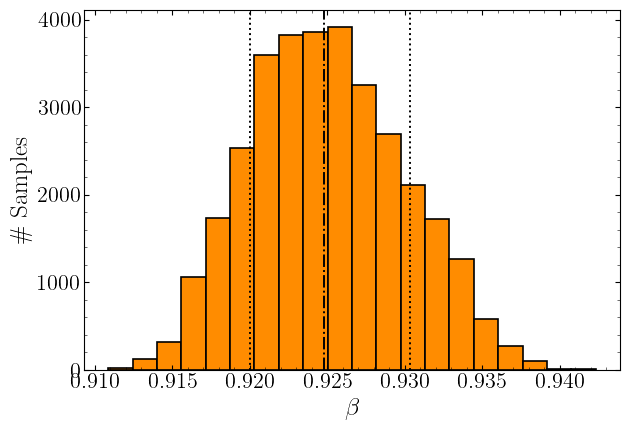

In [40]:
#INITIAL BETA COMPUTATION

import random


beta_array = np.zeros(len(Gamma_0_chain))

for i in range(len(Gamma_0_chain)):
    
                k = random.randint(0, len(Gamma_0_chain)-1)
        
                #j = random.randint(0, len(Gamma_0_chain)-1)

                beta_array[i] = beta(Gamma_0_chain[i])
                
                          
print(("Best estimation of $\beta$ : ", np.quantile(beta_array, .50))) 
print(("Upper error : ", (np.quantile(beta_array, .84) - np.quantile(beta_array, .50))))
print(("Lower error : ", (np.quantile(beta_array, .50) - np.quantile(beta_array, .16)))) 


beta_best = np.quantile(beta_array, .50)
err_plus_beta = np.quantile(beta_array, .84) - np.quantile(beta_array, .50)
err_minus_beta = np.quantile(beta_array, .50) - np.quantile(beta_array, .16)


print(("$\\beta$ best {:e} + {:e} - {:e}".format(beta_best, err_plus_beta, err_minus_beta)))

fig,axes = plt.subplots()
rc('text', usetex=True)

gs = gridspec.GridSpec(1,1)
ax1=plt.subplot(gs[0])

ax1.hist(beta_array, bins = 20, edgecolor='black', linewidth=1.2, color='darkorange')

ax1.axvline(x=np.quantile(beta_array, .84), color='k', linestyle=':')
ax1.axvline(x=np.quantile(beta_array, .50), color='k', linestyle='-.')
ax1.axvline(x=np.quantile(beta_array, .16), color='k', linestyle=':')

ax1.set_xlabel('$\\beta$', fontsize = 18)
#plt.xlabel('Time [MJD $-$ 58500]', fontsize =16)
plt.ylabel('$\#$ Samples', fontsize =18)
#plt.ylim(0, 0.6)
#plt.xlim(0.9, 0.95)
plt.tick_params(axis ='both',which='both',direction = 'in', top=True, right=True, labelsize = 16, pad=2)
plt.minorticks_on()
#plt.xticks(rotation=30)
plt.tight_layout()
#pylab.setp(ax1.get_xticklabels(), visible=False)
plt.savefig("./MAXIJ1820_BETA_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)

(-15.0, 15.0)

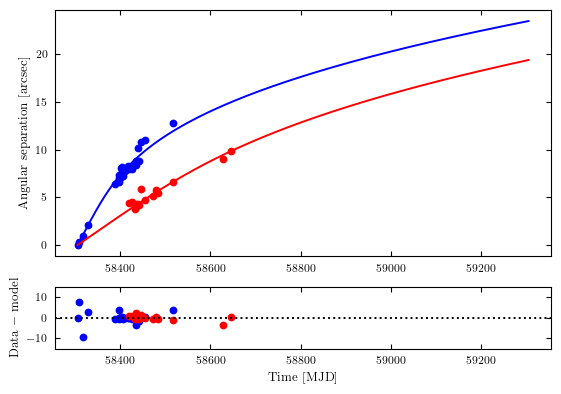

In [41]:
times= np.arange(bestp_final[10]+58300,bestp_final[10]+58300+1000,1)
fig,axes = plt.subplots()
rc('text', usetex=True)

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1=plt.subplot(gs[0])
ax2=plt.subplot(gs[1],sharex=ax1)
if mod_type=='single':
    mod=total_motion(bestp_final,times,'app')
    ax1.plot(Times[0],Ang_Sep[0],marker='o',ls='',color='b')
    ax1.plot(times,mod,color='k')
    #ax1.axhline(y=cavity_angle_arcsec)
    ax1.set_ylabel('Angular separation [arcsec]')
    ax2.set_ylabel('Data $-$ model')
    ax2.set_xlabel('Time [MJD]')
    ax2.plot(Times[0],(Ang_Sep[0]-total_motion(bestp_final,Times[0],'app'))/abs(Ang_Sep_Err[0]),marker='o',ls='',color='b')
elif mod_type=='double':
    mod_app=total_motion(bestp_final,times,'app')
    mod_rec=total_motion(bestp_final,times,'rec')
    ax1.plot(Times[0],Ang_Sep[0],marker='o',ls='',color='b')
    ax1.plot(Times[1],Ang_Sep[1],marker='o',ls='',color='r')
    ax1.plot(times,mod_app,color='b')
    ax1.plot(times,mod_rec,color='r')
    ax1.set_ylabel('Angular separation [arcsec]')
    ax2.set_ylabel('Data $-$ model')
    ax2.set_xlabel('Time [MJD]')
    ax2.plot(Times[0],(Ang_Sep[0]-total_motion(bestp_final,Times[0],'app'))/abs(Ang_Sep_Err[0]),marker='o',ls='',color='b')
    ax2.plot(Times[1],(Ang_Sep[1]-total_motion(bestp_final,Times[1],'rec'))/abs(Ang_Sep_Err[1]),marker='o',ls='',color='r')
ax2.axhline(y=0,ls=':',color='k')
ax2.set_ylim(-15,15)

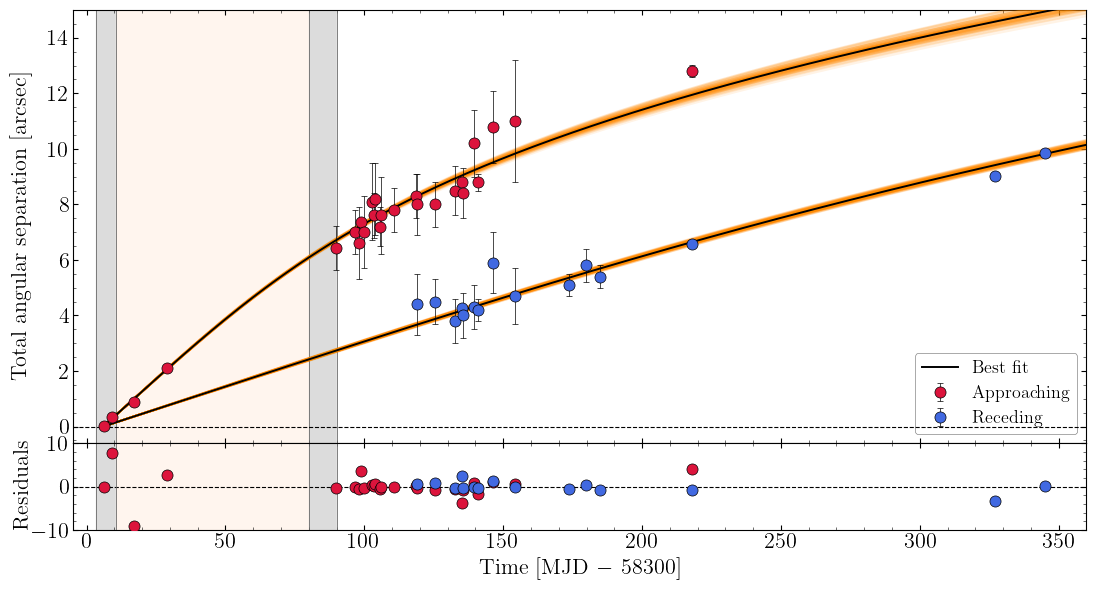

In [79]:
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(11,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])
gs.update(hspace=0)
ax1 = plt.subplot(gs[0])


step_number = 199
gamma0_walker = np.array(sampler.chain[:, step_number, 0].reshape((-1, 1)))
E0_walker = np.array(sampler.chain[:, step_number, 1].reshape((-1, 1)))
theta_walker = np.array(sampler.chain[:, step_number, 2].reshape((-1, 1)))
phi_walker = np.array(sampler.chain[:, step_number, 3].reshape((-1, 1)))
R_c_walker = np.array(sampler.chain[:, step_number, 4].reshape((-1, 1)))
delta_walker = np.array(sampler.chain[:, step_number, 5].reshape((-1, 1)))
zeta_walker = np.array(sampler.chain[:, step_number, 6].reshape((-1, 1)))
D_walker = np.array(sampler.chain[:, step_number, 7].reshape((-1, 1)))
R0_walker = np.array(sampler.chain[:, step_number, 8].reshape((-1, 1)))
n_ism_walker = np.array(sampler.chain[:, step_number, 9].reshape((-1, 1)))
t_ej_walker = np.array(sampler.chain[:, step_number, 10].reshape((-1, 1)))





ax1.errorbar(Times[0]-58300, Ang_Sep[0], yerr=Ang_Sep_Err[0], marker='o',color='crimson', ecolor='black', label='Approaching', linestyle='', capsize=2, elinewidth=0.5, markeredgewidth=0.5, markersize=8, markeredgecolor='black', zorder=10)
ax1.errorbar(Times[1]-58300, Ang_Sep[1], yerr=Ang_Sep_Err[1], marker='o',color='royalblue', ecolor='black', label='Receding', linestyle='', capsize=2, elinewidth=0.5, markeredgewidth=0.5, markersize=8, markeredgecolor='black', zorder=10)


for i in range(10*ndim):
         
        
        times_walker= np.arange(t_ej_walker[i]+58300,t_ej_walker[i]+58300+1000,1)
        
        walker_parameters = [gamma0_walker[i], E0_walker[i], theta_walker[i], phi_walker[i], R_c_walker[i],
                     delta_walker[i], zeta_walker[i], D_walker[i], R0_walker[i], n_ism_walker[i], t_ej_walker[i]]

        model_walker_app = total_motion(walker_parameters,times_walker,'app')
        model_walker_rec = total_motion(walker_parameters,times_walker,'rec')
        
        ax1.plot(times_walker-58300,model_walker_app,color='darkorange', alpha=0.1, zorder=5)
        ax1.plot(times_walker-58300,model_walker_rec,color='darkorange', alpha=0.1, zorder=5)
       

ax1.plot(times-58300,mod_app,color='k', label = 'Best fit', zorder=10)
ax1.plot(times-58300,mod_rec,color='k', label = '', zorder=10)


theta_rad = bestp_final[2]*np.pi/180
#cavity_angle = bestp_final[4] * np.sin(theta_rad) / (1000*bestp_final[7])
#cavity_angle_arcsec_best = cavity_angle * 180/(np.pi) * 3600
#ax1.axhline(y=cavity_angle_arcsec_best, label='Cavity radius')

plt.axhline(y=0.0, color='k', linestyle='--', linewidth=0.8, zorder=10)
#plt.axvline(x=23.21, color='m', linestyle='--', linewidth=0.8, label = 'Flare peak $-$ MeerKAT')



x_ims_1 = 3.5
x_soft = 10.7
x_ims_2 = 80
x_hard = 90


ax1.axvspan(0, x_ims_1, color='white')
ax1.axvspan(x_ims_1, x_soft, color='gainsboro')
ax1.axvspan(x_soft, x_ims_2, color='seashell')
ax1.axvspan(x_ims_2, x_hard, color='gainsboro')
ax1.axvspan(x_hard, 360, color='white')


plt.axvline(x=x_ims_1, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_soft, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_ims_2, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_hard, color='dimgray', linestyle='-', linewidth=0.6)



plt.xlabel('Time [MJD $-$ 58300]', fontsize =16)
plt.ylabel('Total angular separation [arcsec]', fontsize =16)


plt.xlim(-5, 360)
plt.ylim(-0.6, 15)
plt.tick_params(axis ='both',which='both',direction = 'in', top=True, right=True, labelsize = 16, pad=2)
plt.minorticks_on()

legend = plt.legend(loc=4,fontsize=13)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor("dimgray")

ax1.get_yaxis().set_label_coords(-0.04,0.5)

ax2 = plt.subplot(gs[1])


ax2.plot(Times[0]-58300,(Ang_Sep[0]-total_motion(bestp_final,Times[0],'app'))/abs(Ang_Sep_Err[0]),marker='o',ls='',color='crimson', markeredgewidth=0.5, markersize=8, markeredgecolor='black', zorder=10)
ax2.plot(Times[1]-58300,(Ang_Sep[1]-total_motion(bestp_final,Times[1],'rec'))/abs(Ang_Sep_Err[1]),marker='o',ls='',color='royalblue', markeredgewidth=0.5, markersize=8, markeredgecolor='black', zorder=10)

plt.axhline(y=0.0, color='k', linestyle='--', linewidth=0.8)

ax2.get_yaxis().set_label_coords(-0.04,0.5)


ax2.axvspan(0, x_ims_1, color='white')
ax2.axvspan(x_ims_1, x_soft, color='gainsboro')
ax2.axvspan(x_soft, x_ims_2, color='seashell')
ax2.axvspan(x_ims_2, x_hard, color='gainsboro')
ax2.axvspan(x_hard, 360, color='white')


plt.axvline(x=x_ims_1, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_soft, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_ims_2, color='dimgray', linestyle='-', linewidth=0.6)
plt.axvline(x=x_hard, color='dimgray', linestyle='-', linewidth=0.6)




plt.xlabel('Time [MJD $-$ 58300]', fontsize =16)
plt.ylabel('Residuals', fontsize =16)
plt.ylim(-10, 10)
plt.xlim(-5, 360)
plt.tick_params(axis ='both',which='both',direction = 'in', top=True, right=True, labelsize = 16, pad=2)
plt.minorticks_on()
#plt.xticks(rotation=30)
plt.tight_layout()
plt.setp(ax1.get_xticklabels(), visible=False)
plt.savefig("MAXIJ1820_JET_ANGSEP_FIT_WITH_UNCERTAINTIES_1DEG.pdf", bbox_inches='tight', pad_inches = 0.05)

# Doppler factor $\delta^{3-\alpha}$ (flux density)

In [46]:
jet_spix = -0.6
dopp_delta_app = 1./(bestp_final[0] * (1 - beta(bestp_final[0]) * np.cos(bestp_final[2]*np.pi/180)))
print(("Doppler factor on the observed flux for the approaching component {:e}\n".format(dopp_delta_app**(3-jet_spix))))
dopp_delta_rec = 1./(bestp_final[0] * (1 + beta(bestp_final[0]) * np.cos(bestp_final[2]*np.pi/180)))
print(("Doppler factor on the observed flux for the receding component {:e}\n".format(dopp_delta_rec**(3-jet_spix))))

Doppler factor on the observed flux for the approaching component 2.978183e-01

Doppler factor on the observed flux for the receding component 7.757056e-03

